<h1> BBHs merging catalog generator 8.0</h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from the LIGO population papers [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533) and [R. Abbott et al. ](https://arxiv.org/abs/2111.03634).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad, simpson
from scipy.stats import poisson
from scipy.interpolate import interp1d
from multiprocessing import Pool, Manager, Value
from functools import partial
#from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_61151/3968145404.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

mode_ex = False
mode_fastmc = False
mode_poisson = False
SOBBH = False
PBH = False
LIGO_Rz = False
Red_evol = False
PBH_fRz = False
PBH_fRt = False
R_Spike = False
sel_rs = False
Check_Plot = False

# Number of jobs spawned by the multiprocessing part of the program (use 9/10 * number of core to avoid problems)

n_jobs = 80 #(mp.cpu_count() - 4)

# To avoid to saturate the ram when copying the generated list to a dataframe, the process will be made by slicing the list in percentage

cp_perc = 0.25 # If ram >> 16 GB put cp_perc = 1 to do the copy in one single step

# Merger distribution parameters

T_obs = 4. # Lisa estimated years of observation, given by T_mission*Efficiency
max_tc = 1. # max years of coalescence time allowed for a BBH merging event
frq_max = 1000 # Maximum frequency in hertz to which the LISA detector is sensitive

# The total time used to generate the merging events, by multipling for the rate of merging, will be set to max_tc

T_tot = max_tc

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
H_0 = 67.8 # Hubble constant in Km/(s*MPc)
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

mass_prec = 500           # Binning density for the masses
z_prec = 500              # Binning density for the redshift (affect distance density)

<h2> FLAG selection section </h2>

The standard way of simulating the events will be to generate the same predicted number of events in the given bin of variables phase space every time it was run...
To give to the simulation a little bit of randomness, and increase the generation of merging events with low-probability set of variables, set the **exotic_mode** flags to true. 

In [3]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one mode flag may be setup at a single time !**

In [4]:
#mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

Lastly, knowing that the number of events will naturally follow a Poissonian distribution, we can simulate the number of events in each phase space bin by sampling from a poisson distribution, to do this we need to set the **mode_poisson** flag to true :

In [5]:
mode_poisson = True # If True, the predicted number of events in each bin will be used to sample from a Poissonian distribution

For what concerns the catalogue, let's start by choosing if the catalogue will either be _SOBBH_ or 
_PBH_ :

In [6]:
#SOBBH = True # We assume the catalogue has events of stellar origin
PBH = True # We assume the catalogue has events of primordial origin 

We can choose several different Mass Functions for the simulation, these can be selected by using the flag Mass_PDF:

In [7]:
#Mass_PDF = 'LIGO_Fid' # With this flag, we are gonna use the LIGO fiducial model for the mass PDF in the simulation of the catalogue
Mass_PDF = 'LogNorm' # In this case, we are gonna use the Log-Normal mass function used to describe premordial black hole in the paper PhysRevD.96.023514
#Mass_PDF = 'Gaussian' # In this case, we are gonna assume a Gaussian mass PDF as in the paper PhysRevD.96.023514

For what concerns the merging rate, the LIGO merging rate can be choosen by setting to true the LIGO_Rz flag.
As we know from the latest LIGO results that the best fit is with a merging rate that evolve with redshift, we can use the _Star Formation Rate_ presented in [Mangiagli et al.](https://arxiv.org/pdf/1907.12562.pdf) by setting to true the Red_evol flag.

In [8]:
#Red_evol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume

In [9]:
if Red_evol:
    LIGO_Rz = True # If true, the code will use the fiducial LIGO R(z) merging rate

if we want to simulate a _Primordial Black Hole(PBH)_ population, we can set one of the two flags :

In [10]:
#PBH_fRz = True # If true, the merging rate would assumed to be the simple power law evolution of a fixed k, where the value of R0 would be given as a fraction f of the SOBBH one
PBH_fRt = True # If true, the merging rate would assumed to be a powerlaw of the Hubble time at redshift z, where the value of R0 would be given as a fraction f of the SOBBH one 

In general, for generical perturbations to the fiducial model, instead we can use a uniform spike-like merging rate by setting the following flag to true :

In [11]:
#R_Spike = True # If true, the merging rate will just be an uniform value in a certain range of redshift, used for perturbations to the fiducial model

To conclude, we may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [12]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

and we can choose to generate plots to check the correctness of the execution :

In [13]:
Check_Plot = True # If True, the code will generate several plots during the run to check the correctness of the parameters

<h2> Mass distribution functions </h2>

Let's start by defining the probability distribution in function of the masses.

We have :

<h3> LIGO fiducial mass PDFs</h3>

In [14]:
#if Mass_PDF == 'LIGO_Fid':
    # Model B mass distribution function of the paper arxiv 1811.12940

    # Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

    #m_min = 5. # Solar Masses
    #m_max = 50. # Solar Masses
    #alpha = 1.6 # +-1.6 Big Error !
    #beta_q = 6.7 # +4.8 -5.9 Still Big Error !

    # Function for estimating the Phase Space costant of the Mass distribution

    #def ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
    #    
    #    ris = 0.
    #    
    #    for i in range(len(ran_m1)- 1):
    #        for j in range(len(ran_m2)- 1):
    #            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
    #                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
    #                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
    #                q = mid_m2/mid_m1 
    #                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
    #   
    #    return ris

    # Function for the distribution in function of mass (as used in paper arxiv 1811.12940)

    #def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
    #    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
    #        q = m2/m1
    #        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
    #    else :
    #        return 0.

In [15]:
if Mass_PDF == 'LIGO_Fid':
    # Power law + Peak Mass Model of the paper arxiv 2010.14533

    # Mass Distribution parameters (values taken from the results of arxiv 2111.03634)

    m_min = 5.0 # + 0.86 - 1.7  minimum mass allowed by the popolation inference
    m_max = 100. # Solar Masses, taken from the prior of the paper as no real higher mass cutoff was estimated !
    alpha = 3.5 # + 0.6 - 0.56 Power law index
    beta_q = 1.1 # + 1.7 - 1.3  index for m2 power law in q
    delta_m = 4.9 #+ 3.4 - 3.2  used for the low mass smoothing function, generate peak at delta_m + m_min
    lambda_peak = 0.038 # + 0.058 - 0.026 Intensity of the gaussian peak
    mu_m = 34.0 # + 2.6 - 4.0 Location of the Gaussian peak in Solar Masses
    sigma_m = 5.69 # +4.28 - 4.34 Solar Masses

    # Defining of the smoothing function for m close to the minimimum mass

    def MassSmoothing(m, m_min, delta_m):
        if(m < m_min):
            return 0.
        else:
            if(m >= (m_min + delta_m)):
                return 1.
            else:
                factor = np.exp((delta_m/(m - m_min)) + (delta_m/(m - m_min - delta_m)))
                return 1./(factor + 1.)

    # Defining a normalized power law distribution function, needed for the final distribution function        

    def MassPowLaw(m, m_min, m_max, alpha, PL_norm):
        if(m_min < m < m_max):
            return (1./PL_norm)*(m**(-alpha))
        else:
            return 0.

    # Estimating the Phase space of the Power law distribution using trapezoidal integration

    def PowerLawPS(ran_m1, m_min, m_max, alpha):

        mid_m = 0.5*(ran_m1[1::] + ran_m1[:-1:])
    
    
        if min(mid_m) < m_min:
            good_idx = mid_m >= m_min
            mid_m = mid_m[good_idx]

        if max(mid_m) > m_max:
            good_idx = mid_m <= m_max
            mid_m = mid_m[good_idx]

        ris = simpson(np.power(mid_m, (-alpha)), mid_m)

        return ris


    # Defining a Gaussian distribution of the mass, needed for the final distribution function

    def MassGauss(m, mu_m, sigma_m, GS_norm):
        if (m_min < m < m_max):
            return ((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-mu_m)/sigma_m)**2.))*1./GS_norm
        else:
            return 0.
        
    # Estimating the Phase space of the Gaussian distribution using trapezoidal integration

    def GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m):

        mid_m = 0.5*(ran_m1[1::] + ran_m1[:-1:])
    
    
        if min(mid_m) < m_min:
            good_idx = mid_m >= m_min
            mid_m = mid_m[good_idx]

        if max(mid_m) > m_max:
            good_idx = mid_m <= m_max
            mid_m = mid_m[good_idx]

        ris = simpson((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((mid_m- mu_m)/sigma_m)**2.), mid_m)

        return ris

    # Defining the normalization constant for the q dependancy of the total mass distribution

    def P2PS(ran_m2, beta_q, m_min, delta_m):

        q_norm = np.linspace(0,1,len(ran_m2))
        mid_m = 0.5*(ran_m2[1::] + ran_m2[:-1:])
        dm = (ran_m2[1::] - ran_m2[:-1:])

        for i in range(len(ran_m2) - 1):

            q_norm[i] = 0.

            if (m_min <= mid_m[i] <= m_max):

                for j in range(i + 1):

                    q_norm[i] += ((mid_m[j]/(mid_m[i]))**(beta_q))*dm[j]*MassSmoothing(mid_m[j], m_min, delta_m)
            else:
                q_norm[i] = 1.

        q_norm[len(ran_m2) - 1] = q_norm[len(ran_m2) - 2]

        return q_norm  


    # Defining the total Mass distribution function as the sum of two components

    def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm, Mass_PS):

        if(m1 > m2 and m1 <= m_max and m2 <= m_max):
            return ((1. - lambda_peak)*MassPowLaw(m1, m_min, m_max, alpha, PL_norm) + \
                    lambda_peak*MassGauss(m1, mu_m, sigma_m, GS_norm))*MassSmoothing(m1, m_min, delta_m)*\
                    ((m2/m1)**(beta_q))*(1./q_norm)*MassSmoothing(m2, m_min, delta_m)*(1./Mass_PS)
        else:
            return 0.


    # Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

    def ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm):

        mid_m = 0.5*(ran_m1[1::] + ran_m1[:-1:])
        dm = (ran_m1[1::] - ran_m1[:-1:])
        ris = 0.

        if min(mid_m) < m_min:
            good_idx = mid_m >= m_min
            mid_m = mid_m[good_idx]
            dm = dm[good_idx]
            q_norm = q_norm[good_idx]

        if max(mid_m) > m_max:
            good_idx = mid_m <= m_max
            mid_m = mid_m[good_idx]
            dm = dm[good_idx]
            q_norm = q_norm[good_idx]

        for i in range(len(mid_m)):
            for j in range(i + 1):
                        q = mid_m[j]/mid_m[i] 
                        ris +=  dm[i]*dm[j]*\
                        ((1. - lambda_peak)*MassPowLaw(mid_m[i], m_min, m_max, alpha, PL_norm)\
                        + lambda_peak*MassGauss(mid_m[i], mu_m, sigma_m, GS_norm))\
                        *MassSmoothing(mid_m[i], m_min, delta_m)*(q**(beta_q))*(1./q_norm[i])\
                        *MassSmoothing(mid_m[j], m_min, delta_m)

        return ris

<h3> LogNormal Primordial Black Holes mass PDF</h3>

The Log-Normal mass PDF is taken by [B. Carr et al.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.96.023514), and read as :

In [16]:
if Mass_PDF == 'LogNorm':
    # We use the following distribution for the mass
    m_min = 1.e-3 # Solar Masses. Minimum value assumed for the PBH mass
    m_max = 150. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_Mc = 95.00 # Solar masses, taken from the main paper by Bavera
    PBH_sigmamf = 0.10 # Taken from the main paper by Bavera
    
    def MassDistr(m, PBH_Mc, PBH_sigmamf, LN_norm):
        return (1./(np.sqrt(2*np.pi)*PBH_sigmamf*m))*np.exp(-(np.log(m/PBH_Mc)**2)/(2*PBH_sigmamf**2))*1./LN_norm
    
    # This function is to estimate the normalization constant
    def LogNormPS(ran_m, PBH_Mc, PBH_sigmamf):

        PBH_midm = 0.5*(ran_m[1::] + ran_m[:-1:])

        ris =  simpson(MassDistr(PBH_midm, PBH_Mc, PBH_sigmamf, 1.), PBH_midm)
            
        return ris


<h3> Gaussian Primordial Black Holes mass PDFs</h3>

The Gaussian mass PDF can be defined as follows :

In [17]:
if Mass_PDF == 'Gaussian':
    m_min = 61 # Solar Masses, minimal mass assumed for the simulation
    m_max = 83. # Solar Masses, maximal mass assumed for the simulation
    mu_m = 72. # Location of the Gaussian peak in Solar Masses
    sigma_m = 1. # Solar Masses, describe the width of the Gaussian PDF
    
    # We use the following distribution for the mass
    
    def MassDistr(m, mu_m, sigma_m, GS_norm):
        return ((1./(sigma_m*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-mu_m)/sigma_m)**2.))*1./GS_norm
    
    # This function is to estimate the normalization constant
    def GaussPS(ran_m, mu_m, sigma_m):

        PBH_midm = 0.5*(ran_m[1::] + ran_m[:-1:])

        ris =  simpson(MassDistr(PBH_midm, mu_m, sigma_m, 1.), PBH_midm)
            
        return ris

<h3> ChirpMass function </h3>

Regardless of the mass PDF used, we are gonna need a function that return the Chirp Mass, given the mass of the two events involved in the binary merging :

In [18]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

<h2> Redshift dependent statistic </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [19]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

Omega_m = 0.3
Omega_lambda = 0.7
Omega_k = 0.
zmin = 1.e-5 # to avoid SNR divergence due to extremely close events
zmax_log = 1.0 # max z value generated in log scale
zmax_lin = 10.0 # max z value generated in lin scale


def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        span_z = np.linspace(0.,z,z_prec)
        span_mz = 0.5*(span_z[1::] + span_z[:-1:])
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        Int_Z = c*(10**(-3))*simpson(1./(H(span_mz)), span_mz, axis=0)
    
        return Int_Z
        
def Z_to_HubbleTime(z):
    
    zHT_max = 1.e8
    zHT_prec = 10000
        
    # Beware, would fail if the span z is created in logarithmic scale !
    span_z = np.logspace(np.log10(z),np.log10(zHT_max),zHT_prec)
    span_mz = 0.5*(span_z[1::] + span_z[:-1:])
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    
    Int_Z = simpson(1./(H(span_mz)*(1. + span_mz)), span_mz, axis=0)
    
    return Int_Z

to avoid calling that several times, we are gonna define an interpolation function over a fiducial range of values : 

In [20]:
if SOBBH:
    ran_z = np.logspace(np.log10(zmin/2.), np.log10(1.1*zmax_lin), z_prec*100) 
if PBH:
    ran_z = np.logspace(np.log10(zmin/2.), np.log10(1.1*zmax_lin), z_prec*100)
ran_d = Z_to_Gpc(ran_z)
dist_func = interp1d(ran_z, ran_d)
ran_d = 0.

The function that estimates the differential comoving volume in function of the redshift will be the differential comoving volume of the sphere :

In [21]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = dist_func(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = dist_func(z_2) - dist_func(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

We may now define, the merging rate as a function of the redshift _z_ as :

In [22]:
#if LIGO_Rz:
    # Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

    #def R(z):
    #    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [23]:
if LIGO_Rz:
    # Function for the merging rate as described in the paper arxiv 2111.03634, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

    k = 2.9 # + 1.7 - 1.8  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
    Corr_Rz = (((1. + 0.2)**k)/(1. + ((1. + 0.2)/2.9)**(k + 2.9)))**(-1) # Normalization factor estimated at z = 0.2

    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    R_0 = {}
    R_0[0] = 28.3 # +13.9 - 9.1 GPC⁻³ yr^⁻¹ Value of the merging rate fitted at z = 0.2
    R_0[1] = 23.9 # +14.9 - 8.6 GPc^-3 yr^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

    def R(z):
        if(Red_evol):
            # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
            return R_0[0]*Corr_Rz*((1. + z)**k)/(1. + ((1. + z)/2.9)**(k + 2.9))
        else:
            return R_0[1]        


in the case of _PBH_, we start by defining the model presented in [V. Atal et al.](https://arxiv.org/abs/2201.12218) evolving with a simple power broken power law having $k = 1.1$ before $z_*$ and $k = 1.4$ after. :

In [24]:
if PBH_fRz :
    
    zmin = 1.e-5 # to avoid SNR divergence due to extremely close events
    zmax_log = 1.0 # max z value generated in log scale
    zmax_lin = 10.0 # max z value generated in lin scale

    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate
    
    f = 0.005 # Fraction of the LIGO merging rate in the form of PBH
    k = 2.9 # + 1.7 - 1.8  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
    PBH_R0 = 28.3 # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
    PBH_CorrfRz = 1./(1. + 0.2)**k # normalization factor needed to express the value of the LIGO merging rate in z=0
    
    def R(z):
        if(z <= 1.):
            PBH_k = 1.1 # Value taken from arxiv 2201.12218, valid for small z !!
            return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k)
        else:
            PBH_k = 1.4 # Value taken from arxiv 2201.12218, valid for high z !!
            PBH_R1_corr = f*PBH_R0*PBH_CorrfRz*(((2.)**PBH_k) - ((2.)**1.1))
            return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k) - PBH_R1_corr

alternatively, we can use the same model described by [S. S. Bavera et al](https://arxiv.org/pdf/2109.05836.pdf) for the redshift evolution of the merging rate. The amplitude of the perturbation can still be parametrized using the $fR$ approach as in the previous model :

In [25]:
if PBH_fRt:
    zmin = 1.e-5 # to avoid SNR divergence due to extremely close events
    zmax_log = 1.0 # max z value generated in log scale
    zmax_lin = 10.0 # max z value generated in lin scale

    f = 0.007 # Fraction of the LIGO merging rate in the form of PBH
    k = 2.9 # + 1.7 - 1.8  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
    PBH_R0 = 28.3 # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
    PBH_CorrfRz = 1./(1. + 0.2)**k # normalization factor needed to express the value of the LIGO merging rate in z=0
    
    def R(z):
        return f*PBH_R0*PBH_CorrfRz*((t_z(z)/t_0)**(-34./37.))

or for a generical perturbation at a redshift bin we can use :

In [26]:
if R_Spike:
    Rz_min = 4.5
    Rz_max = 5.5
    SOBBH_SpikeAmpl = 3000.
    
    def R(z):
        # Pass the amplitude in units of 1/[yr*GPc], tipically the value is between [1, 200]
        if (z >= Rz_min and z <= Rz_max):
            return SOBBH_SpikeAmpl

In order to better smoothen up the redshift distribution of the generated events, in the case of the LIGO fiducial merging rate, we will use the inverse uniform sampling instead of the normal uniform smoothing for the latters :

In [27]:
if not R_Spike:
    # Generating the inverse uniform sampling function, as described by Jesus Torrado

    zs = np.logspace(np.log10(zmin), np.log10(zmax_log), z_prec*2)
    zs = np.append(zs, np.linspace(zmax_log + (zs[(z_prec*2) - 1] - zs[(z_prec*2) - 2]), zmax_lin, z_prec*100))
    zs = np.sort(zs, kind = 'mergesort')
    rs = np.array([dist_func(z) for z in zs])
    vols = 4/3 * np.pi * rs**3
    spl = interpolate.splrep(zs, vols)
    Vz = lambda z: interpolate.splev(z, spl, der=0)
    DerVz = lambda z: interpolate.splev(z, spl, der=1)
    
    if PBH_fRt:
        t_span = Z_to_HubbleTime(zs)
        t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail 
        t_z = interpolate.interp1d(zs, t_span)
    
    def pdf_z(z):
        return R(z)*DerVz(z) * (T_tot /(1. + z))

    # Estimating the cumulative distribution functions value, the integration will be done by using the quadrature method of scipy
    
    zm = 0.5*(zs[1::] + zs[:-1:])
    dz = zs[1::] - zs[:-1:]
    ZCDF_samples = zm * 0.
    
    for i in range(len(zm)):
        if i == 0:
            ZCDF_samples[i] = dz[i]*pdf_z(zm[i])
        else:
            ZCDF_samples[i] = ZCDF_samples[i - 1] + dz[i]*pdf_z(zm[i])
    #ZCDF_samples = np.array([quad(pdf_z, 0., z, limit = 500, epsabs = 1e-3, epsrel =1e-3)[0] for z in zs])

    # reset arrays to get back ram !
    
    zm = 0.
    dz = 0.
    rs = 0.
    vols = 0.


<h2> Spin distribution functions </h2>

Now let's define the spin amplitude distribution function as a Beta function (Default Spin model of the cited paper) :

In [28]:
#Spin Amplitude Distribution parameter (values taken from the paper arxiv 2010.14533)

Expected_a = 0.26 # +0.09 - 0.07
Var_a = 0.02  # +0.02 - 0.01
a_max = 1.


def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')
else:
     print(r'We obtained $alpha_a = $ ',alpha_a, r' and $beta_a = $', beta_a)

# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

# Defining the inverse cumulative function for the spin amplitudes

spinamp_sample = lambda N, a, b: scst.beta(a, b).rvs(N)

We obtained $alpha_a = $  2.2412000000000005  and $beta_a = $ 6.378800000000001


For what concerns the spin tilt distribution, we will implement a mixture between a Gaussian and an isotropic function (default spin of the cited paper):

In [29]:
#Spin tilt Distribution parameters (values assumed considering the results of arxiv 2010.14533, see equation (6) of 1811.12940 for additional information)

sigma_1 = 0.87 # + 1.08 - 0.45
sigma_2 = 0.87 # + 1.08 - 0.45
zeta = 0.76 # + 0.22 - 0.45

# Spin orientation distribution, zeta = 1 gives a gaussian distribution centered in cos_ti = 1, zeta = 0 will return a isotropic distribution

def SpinOrientDistrib(cos_t1,cos_t2, zeta, sigma_1, sigma_2):
    prob = (1. - zeta)/(4) + ((2.*zeta)/(np.pi))*\
    (np.exp(-((np.power(1. - cos_t1,2.))/(2.*np.power(sigma_1,2.))))/(sigma_1*sc.erf(np.sqrt(2)/sigma_1)))\
    *(np.exp(-((np.power(1. - cos_t2,2.))/(2.*np.power(sigma_2,2.))))/(sigma_2*sc.erf(np.sqrt(2)/sigma_2)))
    return prob

we are going to implement the Inverse cumulative distribution function _ICDF_ even for this _PDF_ , this may be trivially done considering the symmetry of the previous _PDF_ for exchange $cos(t_1) \rightarrow cos(t_2)$.
Let's start by estimating the values over the phase space :

In [30]:
Z = np.zeros((2000,2000))
ran_cos_t1 = np.linspace(-1.,1.,2000)
ran_cos_t2 = np.linspace(-1.,1.,2000)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1)):
    for j in range(len(ran_cos_t2)):
        
        Z[j][i] = SpinOrientDistrib(X[j][i], Y[j][i], zeta, sigma_1, sigma_2)

We may now marginalize over $cos(t_2)$ to obtain $P(cos(t_1))$, due to the simmetry in the _PDF_ the latter would be equal to $P(cos(t_2))$, and hence we may estimate the common _ICDF_ on the cumulative function of the first:

In [31]:
Int_Val = np.linspace(0,1,2000) # Array for the marginalization of the spin tilt distribution over cos(t2)
Cum_Val = np.linspace(0,1,2000) # Array for the cumulative distribution of the spin tilt over cos(t_1)

# For a linear scale, the Delta_cos is supposed to be constant

Delta_cos = (ran_cos_t2[1] - ran_cos_t2[0])

#Estimating the marginalization over cos(t2) to obtain P(cos(t1))

for i in range(len(ran_cos_t1)):
    Int_Val[i] = 0.
    for j in range(len(ran_cos_t2)):
        Int_Val[i] += Delta_cos*Z[j][i]
        
# Estimating the cumulative distribution of the resulting marginalized probability  P(cos(t1)) in function of cos(t1)
        
for i in range(len(ran_cos_t1)):
    Cum_Val[i] = 0.
    
    if(i == 0):
        Cum_Val[i] = Delta_cos*Int_Val[i]
    else :
        Cum_Val[i] = Delta_cos*Int_Val[i] + Cum_Val[i - 1]

Once we renormalize the cumulative function, the sample from the _PDF_ may be easily done using the function <em>spintilt_sample</em>:

In [32]:
# To 0-1 range
Cum_Val = (Cum_Val - min(Cum_Val)) / (max(Cum_Val) - min(Cum_Val))
# Invert
spl_inv_spintilt = interpolate.splrep(Cum_Val, ran_cos_t1)

def spintilt_sample(N):
    return interpolate.splev(np.random.random(N), spl_inv_spintilt)

<h2> Number of events in function of the parameters </h2>

We may finally define the distribution function for the number of events :

In [33]:
# Density function for the events in function of the parameters, taken from the original paper arxiv 1811.12940 

def NDistrib(z, m1, m2, Delta_z, m21_norm = []):
    if Mass_PDF == 'LIGO_Fid':
        n = R(z)*DeVC(z, Delta_z)*(T_tot /(1. + z)) \
        *MassDistr(m1, m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, m21_norm , Mass_PS)
    
    if Mass_PDF == 'LogNorm':
        n = R(z)*DeVC(z, Delta_z)*(T_tot /(1. + z)) \
        *MassDistr(m1, PBH_Mc, PBH_sigmamf, LN_norm)*MassDistr(m2, PBH_Mc, PBH_sigmamf, LN_norm)
        
    if Mass_PDF == 'Gaussian':
            n = R(z)*DeVC(z, Delta_z)*(T_tot /(1. + z)) \
            *MassDistr(m1, mu_m, sigma_m, GS_norm)*MassDistr(m2, mu_m, sigma_m, GS_norm)
                
    return n

<h2> Frequency of the generated events </h2>

Here we implement a function to roughly estimate the initial orbital frequency of the event given the massess and the residual coalescence time, as taken by **equation 11 a)** of [S. Marsat and J. G. Baker](https://arxiv.org/pdf/1806.10734.pdf); from that equation we may also estimate the residual time for the events frequency to go outside of the LISA band.
We need to remember that the coalescence time and the maximum frequency in the two following functions need to be redshifted in the source frame, we have :

In [34]:
#This function given the mass of the two events and the redshifted residual time to coalescence, return the initial frequency of the event at the LISA detection time in the source frame
def GetInitialFrequency(m1,m2,coal_T):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = ((256.*ni)/(5.*np.power((c*(10.**3.)),5.)))*np.power((G*M*sol_mass),(5./3.))*coal_T
    return (np.power(res,(-(3./8.)))/np.pi)

In [35]:
#This function given the mass of the two events and the max frequency detectable in the source frame, return the residual time that the event will spend on the Lisa band in the source frame
def TimeOutFrqRange(m1,m2,f_max):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = (5.*np.power((c*(10.**3.)),5.))/(256.*ni*np.power((np.pi*f_max),(8./3.))*np.power((G*M*sol_mass),(5./3.)))
    return res/year

<h2> Functions for the generation of the catalogue </h2>

Let's start by defining a function that randomly generate a name for the single events, just to make the result appear sexier :

In [36]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    nid = str(random.randrange(1000) + 1)
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return "GW"+ str(random.randrange(34,37))+ month + day +"NId"+ nid


We may hence define a function that will give a uniform random value in the considered phase space bin, this function will smoothen up the values of the generated catalogue in order to not have a single representant parameter for each of the considered bin :

In [37]:
# Generate a number of events equal to the lenght of the array N_EvXBin, with random values in the phase deltavolume for each of the parameter

def Gen_Events_Parameters(idx_m1, idx_m2, idx_z) :
                                
        ev_m1 = random.uniform(ran_m1[idx_m1],ran_m1[idx_m1 + 1])
        ev_m2 = random.uniform(ran_m2[idx_m2],ran_m2[idx_m2 + 1])
        
        # By convention we impose that m1 is the biggest mass among the 2
        
        if(ev_m2 > ev_m1):
            app = ev_m1
            ev_m1 = ev_m2
            ev_m2 = app
        
        
        # Defining the redshift of the event
        
        if not R_Spike:
            # We use ICDF, the next lines are to avoid overshooting of the spline function
            ev_z = 1.5*zmax_lin
            while(ev_z > zmax_lin):
                ev_z = float(interpolate.splev(np.random.random(), IZCDF[idx_z]))
        else:
            ev_z = random.uniform(ran_z[idx_z],ran_z[idx_z + 1])
        
        # Now defining time to coalescence and initial frequency in the detector frame
        
        ev_ttilde = random.uniform(1.e-5, max_tc)/(1 + ev_z) # Coalescence time in the source frame                    
        ev_ifrq = (1./(1. + ev_z))*GetInitialFrequency(ev_m1, ev_m2,ev_ttilde*year) # Initial frequency in the detector frame
        
         
        # If the event frequency is within the LISA band the others parameters would be generated, in the other case the event is rejected 
        
        if(ev_ifrq <= frq_max):
            
            BH = pd.DataFrame([[ev_z, ev_m1, ev_m2, ev_ifrq, ev_ttilde],],\
                            columns = ['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'CoalTime'])
            return BH
        else:
            BH = pd.DataFrame({'none' : []})
            return BH
            
            
          
                

<h2> Parallelized function for the generation of the population </h2>

In [38]:
# This function, will parallelize the nested cycles by splitting them in function of the mass_1 bin, each process will then estimate the number of events for the given mass_1 bin and generate the events to append to the dataframe

def init_globals(Nr,Ne,Prc):
    global Nreal,Nev,Perc
    Nreal = Nr
    Nev = Ne
    Perc = Prc

def  Bin_and_Gen(d,im1) :
    # Let's use the fact that the mass probability distribution gives 0 for m2 > m1 to only compute events for bins with m2 < m1
    for im2 in (range(im1 + 1)):
        
        for iz in range(len(ran_z) - 1):

            # estimating the value of NDistrib in function of the values, the value will be interpolated with the trapeze method
            if Mass_PDF == 'LIGO_Fid':
                
                nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]), st.mean([ran_m1[im1],ran_m1[im1 + 1]]),\
                                  st.mean([ran_m2[im2],ran_m2[im2 + 1]]), (ran_z[iz +1] - ran_z[iz]), m21_norm = q_norm[im1])
            else:
                
                nstep =  2.*NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]), st.mean([ran_m1[im1],ran_m1[im1 + 1]]),\
                                  st.mean([ran_m2[im2],ran_m2[im2 + 1]]), (ran_z[iz +1] - ran_z[iz]))
                                
            # to obtain the real result of the integral, we now need to multiply by the values of the delta of all the integration variables  

            nstep *= (ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])

            # Adding the fraction of events to the cumulative sum

            with Nreal.get_lock():            
                Nreal.value += nstep 

            # Checking if mode_fast_mc and implementing

            if(mode_fastmc):
                if(nstep >=1.):
                    if(nstep - round(nstep) >= 0):
                        res = nstep - round(nstep)
                        if(np.random.random() <= res):
                            nstep = round(nstep) + 1.
                    else:
                        res = nstep + 1. - round(nstep)
                        if(np.random.random() > res):
                            nstep = round(nstep) - 1.
                else:
                    if(np.random.random() <= nstep):
                        nstep = 1.

            # Checking if mode exotic

            if(mode_ex):
                nstep += (np.random.random()*0.5)
            
            # Checking if mode poisson
            
            if(mode_poisson):
                nstep = poisson(nstep).rvs()

            # The value need to be round up to an integer
            nstep = round(nstep)

            with Nev.get_lock():
                Nev.value += int(nstep)

            # The estimated number of events will now be generated

            for i in range(int(nstep)):
                delta_BH = Gen_Events_Parameters(im1, im2, iz)
                if(not delta_BH.empty):
                    d.append(delta_BH)

    # Increase the percentage index and print percentage
    
    with Perc.get_lock():
         Perc.value += 1
         if(Perc.value%int((len(ran_m1)-1)/10) == 0):
            print('Percentage of completition : ',(Perc.value*100.)/(len(ran_m1)-1), '%')

<h2> Colormaps of the probability functions and check of reliability </h2>

Let's plot the colormaps of the probability functions to check how they behave, we start with the mass distribution :

The integrated probability for all possible mass pairs  before normalization is :  0.41832756157321926


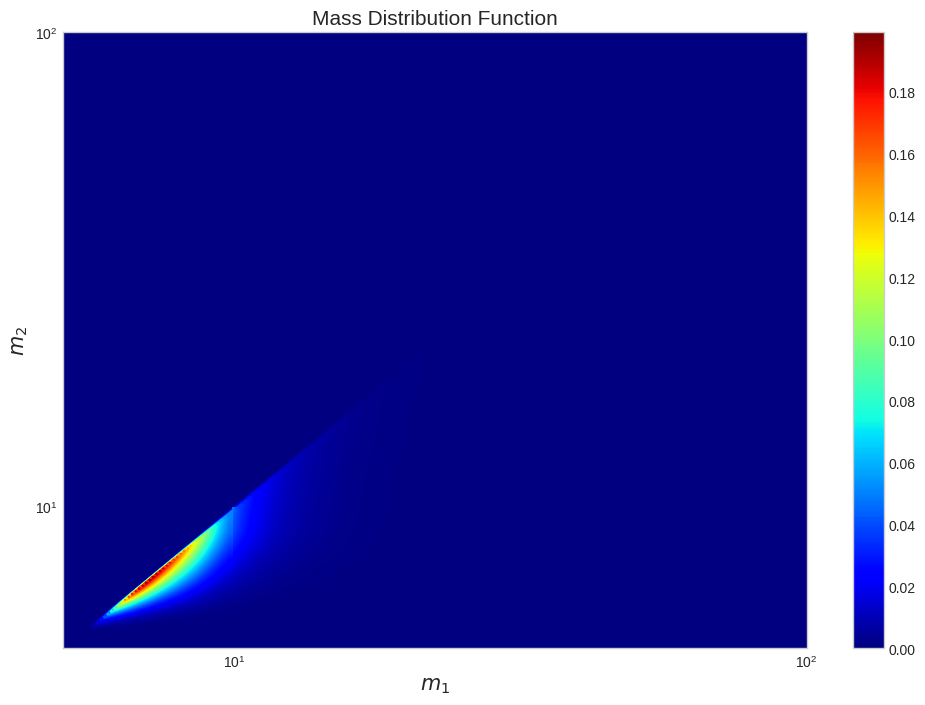

In [39]:
# Colormap of the mass distribution function

if Check_Plot:
    
    if Mass_PDF == 'LIGO_Fid':
        # Need a special mass binning to catch well the model features
        ran_m1 = np.logspace(np.log10(m_min),np.log10(m_min + delta_m), int(mass_prec/10))
        ran_m1 = np.append(ran_m1, np.linspace(m_min + delta_m, m_max, mass_prec))
        ran_m1 = np.sort(ran_m1, kind = 'mergesort')
        ran_m2 = ran_m1
        Z = np.zeros((int(mass_prec*11/10),int(mass_prec*11/10)))
        
    if (Mass_PDF == 'LogNorm' or Mass_PDF == 'Gaussian'):
        ran_m1 = np.linspace(m_min, m_max, mass_prec)
        ran_m2 = ran_m1
        Z = np.zeros((int(mass_prec),int(mass_prec)))
        
    X, Y = np.meshgrid(ran_m1, ran_m2)

    # Mass distribution model B used for the simulation with the values of arxiv 1811.12940

    # MassPhaseSpace = ModBPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)

    if Mass_PDF == 'LIGO_Fid':
        # Mass distribution model C used for the simulation with the values of arxiv 2111.03634
        PLPS = PowerLawPS(ran_m1, m_min, m_max, alpha)
        GSPS = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m)
        q_norm = P2PS(ran_m2, beta_q, m_min, delta_m)
        Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS, q_norm)
    
    if Mass_PDF == 'LogNorm':
        Mass_PS = LogNormPS(ran_m1, PBH_Mc, PBH_sigmamf)
        
    if Mass_PDF == 'Gaussian':
        Mass_PS = GaussPS(ran_m1, mu_m, sigma_m)
                    
    print('The integrated probability for all possible mass pairs  before normalization is : ', Mass_PS) 

    for i in range(len(ran_m1) -1):
        for j in range(len(ran_m2) - 1):

            # Value of the colormap for the mass distribuction used in arxiv 1811.12940, it is estimated with a trapezoid formula to avoid singularities in the extremes

            # Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))

            # Value of the colormap for the mass distribuction used in arxiv 2010.14533, it is estimated with a trapezoid formula to avoid singularities in the extremes
            
            if Mass_PDF == 'LIGO_Fid':
                Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                                    mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
            
            if Mass_PDF == 'LogNorm':
                    Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]),PBH_Mc, PBH_sigmamf, Mass_PS)* MassDistr(0.5*(Y[j][i] + Y[j + 1][i]),PBH_Mc, PBH_sigmamf, Mass_PS)
            
            if Mass_PDF == 'Gaussian':
                    Z[j][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), mu_m, sigma_m, Mass_PS)* MassDistr(0.5*(Y[j][i] + Y[j + 1][i]), mu_m, sigma_m, Mass_PS)
            
            # Fulfill the borders of the colormap by extending the nearest value

            if(i == (len(ran_m1) -2)):
                
                #Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
                
                if Mass_PDF == 'LIGO_Fid':
                    Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                                          mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
                if Mass_PDF == 'LogNorm':
                    Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]),PBH_Mc, PBH_sigmamf, Mass_PS)* MassDistr(0.5*(Y[j][i] + Y[j + 1][i]),PBH_Mc, PBH_sigmamf, Mass_PS)
                
                if Mass_PDF == 'Gaussian': 
                    Z[j][i+1] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), mu_m, sigma_m, Mass_PS)* MassDistr(0.5*(Y[j][i] + Y[j + 1][i]), mu_m, sigma_m, Mass_PS)                                                                                           
            
            if(j == (len(ran_m2) -2)):
                
                #Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
                
                if Mass_PDF == 'LIGO_Fid':                                                                                          
                    Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j + 1][i]), m_min, m_max, alpha, beta_q, delta_m, lambda_peak,\
                                      mu_m, sigma_m, PLPS, GSPS, q_norm[i], Mass_PS)
            
                if Mass_PDF == 'LogNorm':
                    Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]),PBH_Mc, PBH_sigmamf, Mass_PS)*MassDistr(0.5*(Y[j][i] + Y[j + 1][i]),PBH_Mc, PBH_sigmamf, Mass_PS)
                
                if Mass_PDF == 'Gaussian': 
                    Z[j+1][i] = MassDistr(0.5*(X[j][i] + X[j][i + 1]), mu_m, sigma_m, Mass_PS)*MassDistr(0.5*(Y[j][i] + Y[j + 1][i]), mu_m, sigma_m, Mass_PS)                                                                                           
            
    # Choosing values for the last cornerpoints
                                                                                                         
    if Mass_PDF == 'LIGO_Fid': 
        Z[len(ran_m2) - 1][len(ran_m1) -1] = MassDistr(0.5*(X[len(ran_m2) - 1][len(ran_m1) -2] + X[len(ran_m2) - 1][len(ran_m1) -1]),\
                                                       0.5*(Y[len(ran_m2) - 2][len(ran_m1) - 1] + Y[len(ran_m2) - 1][len(ran_m1) -1]),\
                                                       m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PLPS, GSPS,\
                                                       q_norm[len(ran_m1) -1], Mass_PS)
    if Mass_PDF == 'LogNorm':
        Z[len(ran_m2) - 1][len(ran_m1) -1] = MassDistr(0.5*(X[len(ran_m2) - 1][len(ran_m1) -2] + X[len(ran_m2) - 1][len(ran_m1) -1]),PBH_Mc, PBH_sigmamf, Mass_PS)*\
                                             MassDistr(0.5*(Y[len(ran_m2) - 2][len(ran_m1) - 1] + Y[len(ran_m2) - 1][len(ran_m1) -1]),PBH_Mc, PBH_sigmamf, Mass_PS)
    
    if Mass_PDF == 'Gaussian':
        Z[len(ran_m2) - 1][len(ran_m1) -1] = MassDistr(0.5*(X[len(ran_m2) - 1][len(ran_m1) -2] + X[len(ran_m2) - 1][len(ran_m1) -1]), mu_m, sigma_m, Mass_PS)*\
                                             MassDistr(0.5*(Y[len(ran_m2) - 2][len(ran_m1) - 1] + Y[len(ran_m2) - 1][len(ran_m1) -1]), mu_m, sigma_m, Mass_PS)                                                                                                     
    
                                                                                                                                                                                                                   
    # Plotting the countour plot

    plt.figure(figsize=(12,8))
    plt.contourf(X, Y, Z, 250, cmap='jet')
    plt.colorbar();
    plt.xlabel(r'$m_1$', fontsize = 15)
    plt.ylabel(r'$m_2$', fontsize = 15)
    plt.title('Mass Distribution Function', fontsize = 15)
    plt.loglog()
    plt.savefig('MassDistrib.png',dpi=500)

we may also plot the marginalization over $m_2$ to check if we get back the $P(m_1)$ :

In [40]:
if Check_Plot:

    Int_Val = np.linspace(0,1,len(ran_m1))

    for i in range(len(ran_m1)):
        Int_Val[i] = 0.
        for j in range(len(ran_m2)-1):
            Int_Val[i] += (ran_m2[j + 1] - ran_m2[j])*Z[j][i]

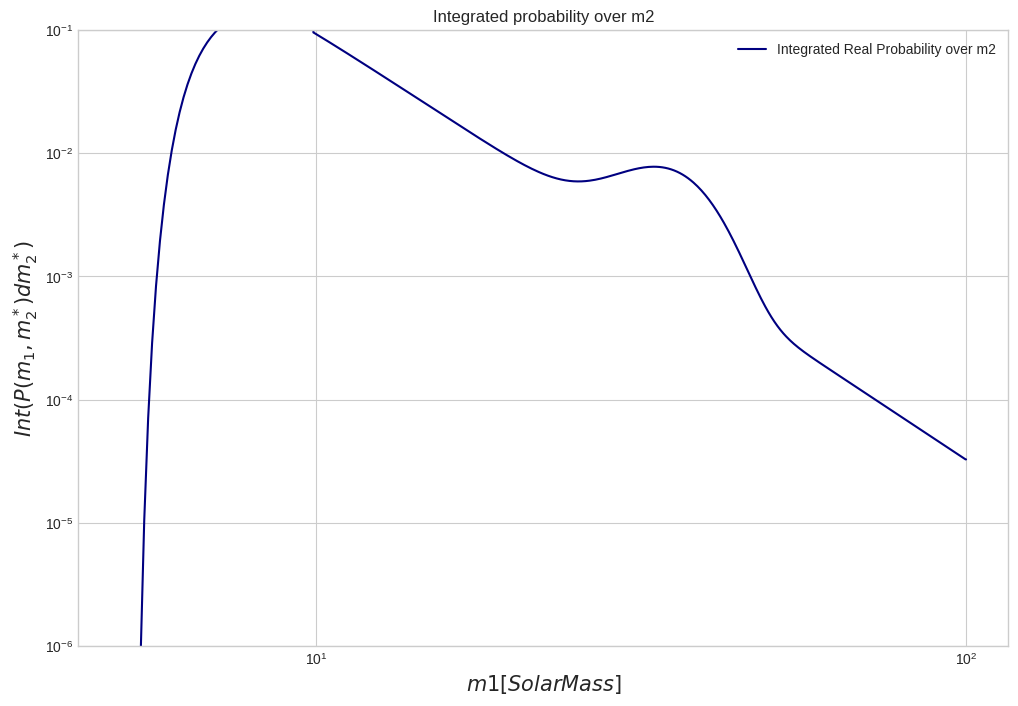

In [41]:
# Plotting the integration of the mass distribution over m2 for each m1

if Check_Plot:

    plt.figure(figsize=(12,8))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(ran_m1, Int_Val, color = 'navy', label = 'Integrated Real Probability over m2')
    plt.ylim(10**(-6),0.1)
    plt.xlabel('$m1 [Solar Mass]$', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('$Int(P(m_1, m_2^*) dm_2^*) $', fontsize = 15)
    plt.title('Integrated probability over m2')
    plt.savefig('MarginalizedProbabilityOverM2.png',dpi=500)

For what concerns the spin amplitudes, the colormap will behave as follow :

The integrated probability for all possible spin amplitudes is :  1.0000000000000084


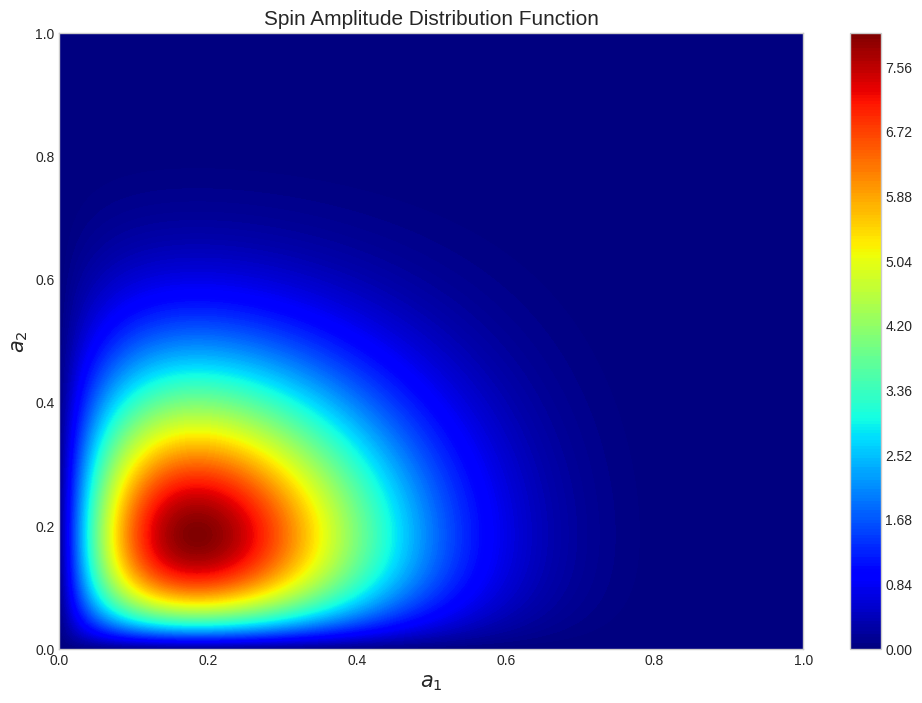

In [42]:
# Colormap of the spin amplitude distribution function, it may be observed the symmetry for swaps among a_1 and a_2

if Check_Plot:

    Z = np.zeros((250,250))
    ran_a1 = np.linspace(0.,a_max,250)
    ran_a2 = np.linspace(0.,a_max,250)
    BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
    X, Y = np.meshgrid(ran_a1, ran_a2)

    for i in range(len(ran_a1) -1):
        for j in range(len(ran_a2) -1):
            Z[j][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)

            # Fulfill the borders of the colormap by extending the nearest value

            if(i == (len(ran_a1) -2)):
                Z[j][i+1] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)
            if(j == (len(ran_m2) -2)):
                Z[j+1][i] = SpinModDistrib(0.5*(X[j][i] + X[j][i + 1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[j][i] + Y[j+1][i]), alpha_a, beta_a, BetaVal)

    Z[len(ran_a2) - 1][len(ran_a1) -1] = SpinModDistrib(0.5*(X[len(ran_a2) - 1][len(ran_a1)-2] + X[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)*SpinModDistrib(0.5*(Y[len(ran_a2) - 2][len(ran_a1) -1] + Y[len(ran_a2) - 1][len(ran_a1) -1]), alpha_a, beta_a, BetaVal)

    # Plotting the countour plot

    plt.figure(figsize=(12,8))
    plt.contourf(X, Y, Z, 250, cmap='jet')
    plt.colorbar();
    plt.xlabel(r'$a_1$', fontsize = 15)
    plt.ylabel(r'$a_2$', fontsize = 15)
    plt.title('Spin Amplitude Distribution Function', fontsize = 15)
    plt.savefig('SpinAmpDistrib.png',dpi=500)

    # Testing also the integrated total probability

    totprob = 0.

    for i in range(len(ran_a1)-1):
        for j in range(len(ran_a2)-1):
            totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

    print('The integrated probability for all possible spin amplitudes is : ', totprob)        

and again, we may plot the marginalization over $a_2$ to check if we get back the $P(a_1)$ :

In [43]:
if Check_Plot:

    Int_Val = np.linspace(0,1,250)
    for i in range(len(ran_a1)):
        Int_Val[i] = 0.
        for j in range(len(ran_a2)-1):
            Int_Val[i] += (ran_a2[j + 1] - ran_a2[j])*Z[j][i]

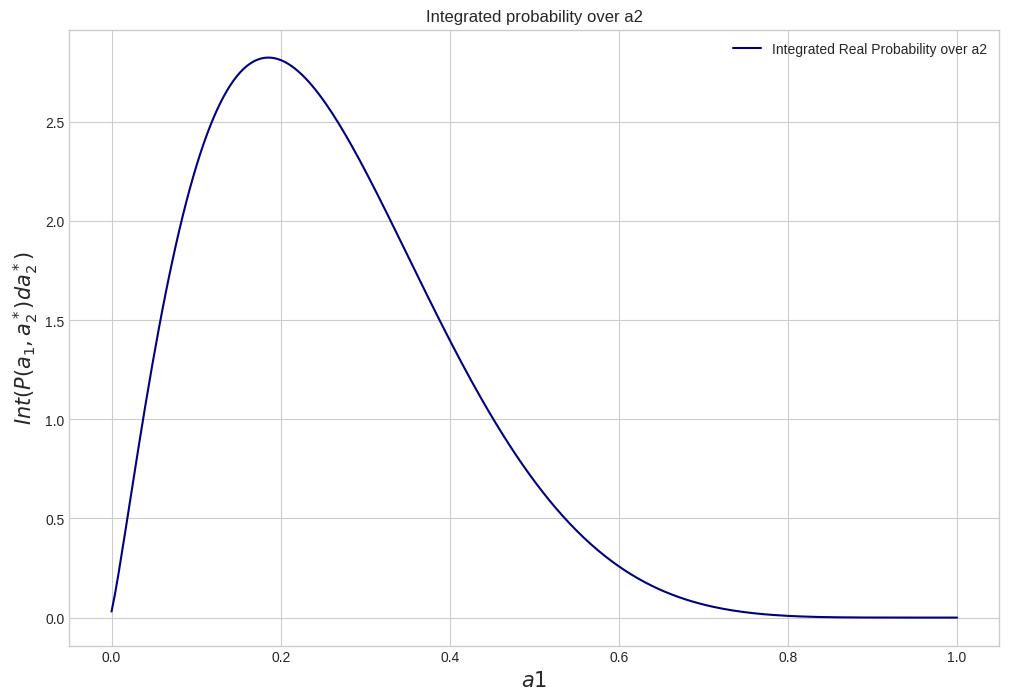

In [44]:
# Plotting the integration of the spin amplitude distribution over a2 for each a1

if Check_Plot:

    plt.figure(figsize=(12,8))
    plt.plot(ran_a1, Int_Val, color = 'navy', label = 'Integrated Real Probability over a2')
    plt.xlabel('$a1$', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('$Int(P(a_1, a_2^*) da_2^*) $', fontsize = 15)
    plt.title('Integrated probability over a2')
    plt.savefig('MarginalizedProbabilityOverSpinAmplitude2.png',dpi=500)

The last PDF for which the colormaps has to be shown is the Spin tilt distribution, we have :

The integrated probability for all possible tilt angles is :  1.0000007204231358


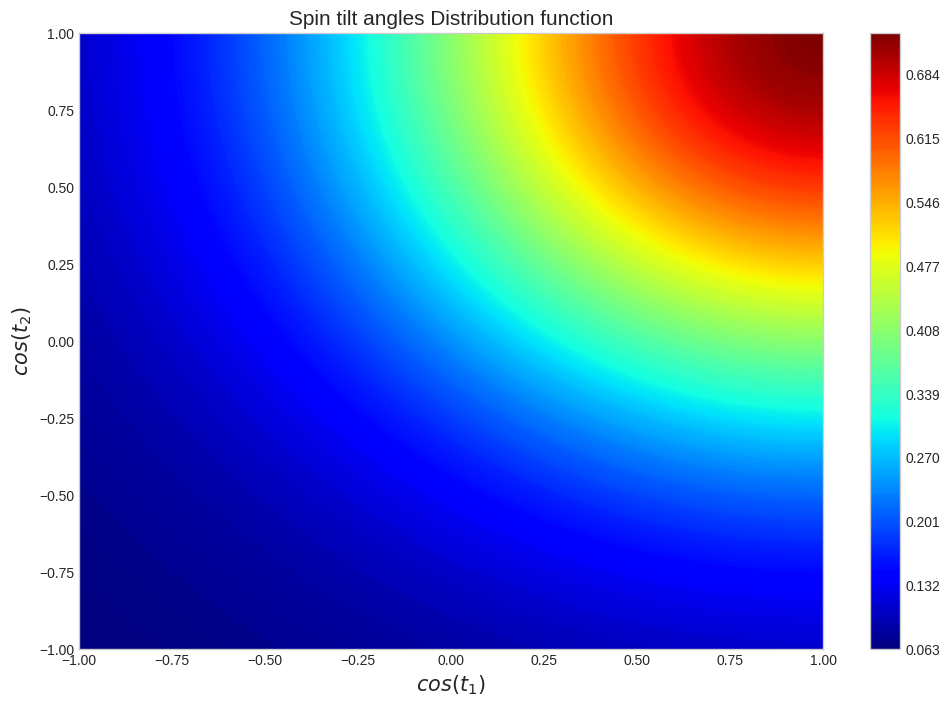

In [45]:
# Colormap of the spin tilt distribution function, it may be observed the symmetry for swap between cos(t1) and cos(t2)

if Check_Plot:

    Z = np.zeros((250,250))
    ran_cos_t1 = np.linspace(-1.,1.,250)
    ran_cos_t2 = np.linspace(-1.,1.,250)
    X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

    for i in range(len(ran_cos_t1) -1):
        for j in range(len(ran_cos_t2) -1):

            Z[j][i] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)

            # Fulfill the borders of the colormap by extending the nearest value

            if(i == (len(ran_cos_t1) -2)):
                Z[j][i+1] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)
            if(j == (len(ran_cos_t2) -2)):
                Z[j+1][i] = SpinOrientDistrib(0.5*(X[j][i] + X[j][i + 1]), 0.5*(Y[j][i] + Y[j+1][i]), zeta, sigma_1, sigma_2)

    Z[len(ran_cos_t2) - 1][len(ran_cos_t1) -1] = SpinOrientDistrib(0.5*(X[len(ran_cos_t2) - 1][len(ran_cos_t1) -2] + X[len(ran_cos_t2) - 1][len(ran_cos_t1) -1]), 0.5*(Y[len(ran_cos_t2) - 2][len(ran_cos_t1) -1] + Y[len(ran_cos_t2) - 1][len(ran_cos_t1) -1]), zeta, sigma_1, sigma_2)

    # Plotting the countour plot

    plt.figure(figsize=(12,8))
    plt.contourf(X, Y, Z, 250, cmap='jet')
    plt.colorbar();
    plt.xlabel(r'$cos(t_1)$', fontsize = 15)
    plt.ylabel(r'$cos(t_2)$', fontsize = 15)
    plt.title('Spin tilt angles Distribution function', fontsize = 15)
    plt.savefig('SpinTiltDistrib.png',dpi=500)

    # Testing also the integrated total probability

    totprob = 0.

    for i in range(len(ran_cos_t1)-1):
        for j in range(len(ran_cos_t2)-1):
            totprob += (ran_cos_t1[i + 1] - ran_cos_t1[i])*(ran_cos_t2[j + 1] - ran_cos_t2[j])*SpinOrientDistrib(st.mean([ran_cos_t1[i],ran_cos_t1[i + 1]]), st.mean([ran_cos_t2[j],ran_cos_t2[j + 1]]), zeta, sigma_1, sigma_2)

    print('The integrated probability for all possible tilt angles is : ', totprob)

which once marginalized over $cos(t_2)$ gives the following $P(cos(t_1))$ :

In [46]:
if Check_Plot:

    Int_Val = np.linspace(0,1,250)
    for i in range(len(ran_cos_t1)):
        Int_Val[i] = 0.
        for j in range(len(ran_cos_t2)-1):
            Int_Val[i] += (ran_cos_t2[j + 1] - ran_cos_t2[j])*Z[j][i]

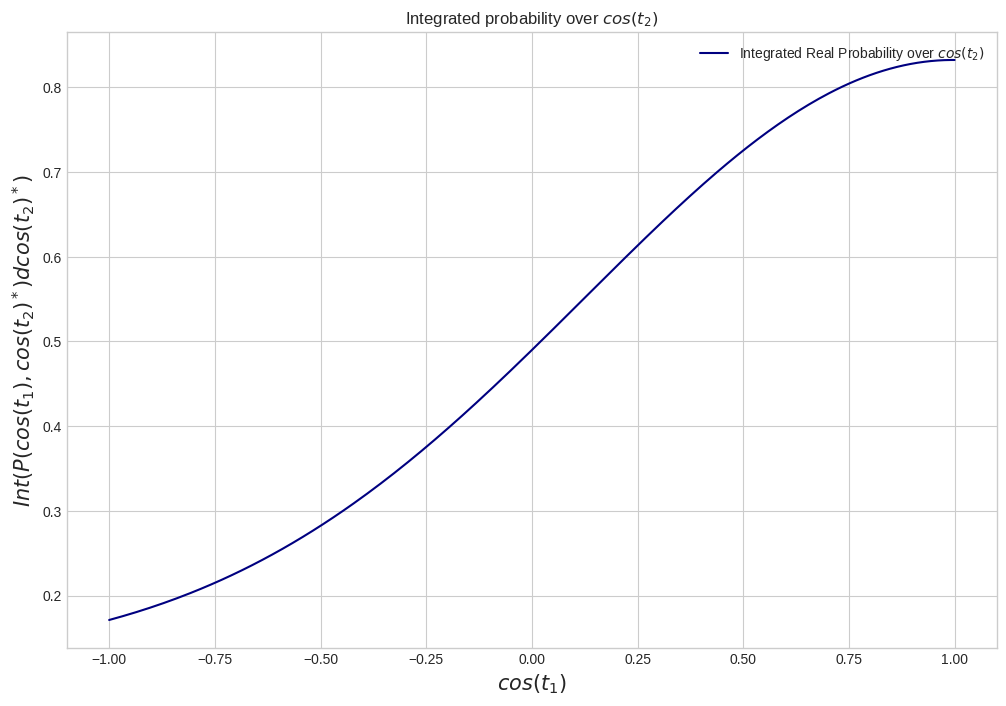

In [47]:
# Plotting the integration of the spin amplitude distribution over a2 for each a1

if Check_Plot:

    plt.figure(figsize=(12,8))
    plt.plot(ran_cos_t1, Int_Val, color = 'navy', label = 'Integrated Real Probability over $cos(t_2)$')
    plt.xlabel('$cos(t_1)$', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('$Int(P(cos(t_1), cos(t_2)^*) d cos(t_2)^*) $', fontsize = 15)
    plt.title('Integrated probability over $cos(t_2)$')
    plt.savefig('MarginalizedProbabilityOverSpinTilt2.png',dpi=500)

Let's reset the predefined array to avoid RAM consumption :  

In [48]:
if Check_Plot:

    X, Y, Z = np.zeros(1),np.zeros(1),np.zeros(1)

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [50]:
# Initialization of the mass phase space

if Mass_PDF == 'LIGO_Fid':
    # Need a special mass binning to catch well the model features
    ran_m1 = np.logspace(np.log10(m_min),np.log10(m_min + delta_m), int(mass_prec/10))
    ran_m1 = np.append(ran_m1, np.linspace(m_min + delta_m, m_max, mass_prec))
    ran_m1 = np.sort(ran_m1, kind = 'mergesort')
    ran_m2 = ran_m1
    PL_norm = PowerLawPS(ran_m1, m_min, m_max, alpha)
    GS_norm = GaussPS(ran_m1, m_min, m_max, mu_m, sigma_m) 
    app = P2PS(ran_m2, beta_q, m_min, delta_m)
    q_norm = 0.5*(app[1::] + app[:-1:])
    Mass_PS = ModCPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q, delta_m, lambda_peak, mu_m, sigma_m, PL_norm, GS_norm, q_norm)

if (Mass_PDF == 'LogNorm' or Mass_PDF == 'Gaussian'):
    ran_m1 = np.linspace(m_min, m_max, mass_prec)
    ran_m2 = ran_m1    
    
if Mass_PDF == 'LogNorm':
    LN_norm = LogNormPS(ran_m1, PBH_Mc, PBH_sigmamf)
        
if Mass_PDF == 'Gaussian':
    GS_norm = GaussPS(ran_m1, mu_m, sigma_m)    

# Initialization of the distance phase space !    
    
if not R_Spike:
    # We will use a logarithmic scale up to z = zmax_log and a linear from zmax_log to zmax_lin to represent the fiducial LIGO model
    ran_z = np.logspace(np.log10(zmin), np.log10(zmax_log), int(z_prec/10))
    ran_z = np.append(ran_z, np.linspace(zmax_log + (ran_z[int(z_prec/10)-1] - ran_z[int(z_prec/10)-2]), zmax_lin, z_prec))
    ran_z = np.sort(ran_z, kind = 'mergesort')
    # We need to recompute the inverse cumulative distribution functions for the redshift population

    IZCDF ={}

    for iz in range(len(ran_z) - 1):
            idx_zmin = (np.abs(zs - ran_z[iz])).argmin()
            idx_zmax = (np.abs(zs - ran_z[iz + 1])).argmin()

            ZCDF_slice = ZCDF_samples[idx_zmin:idx_zmax]

            # To 0-1 range

            ZCDF_slice = (ZCDF_slice - min(ZCDF_slice)) / (max(ZCDF_slice) - min(ZCDF_slice))
            ZCDF_slice = np.sort(ZCDF_slice, kind = 'mergesort')
            # Invert

            IZCDF[iz] = interpolate.splrep(ZCDF_slice, zs[idx_zmin:idx_zmax]) # Values need to be sorted from smallest to biggest !!!

else:
    Rz_min = 2.5
    Rz_max = 3.5
    ran_z = np.linspace(Rz_min,Rz_max, int(z_prec/10))
    

and the result will be saved in the BHCat dataframe :

In [51]:
if not PBH:
    BHCat = pd.DataFrame(columns=['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'InBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
if PBH:
    BHCat = pd.DataFrame(columns=['Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
# The Lisa Dataframe will be saved without name to avoid unnecessary ram consumption

SOBBHsunits = {

'Redshift': 'Unit',\
    
'Mass1': 'SolarMass',\
    
'Mass2': 'SolarMass',\

'InitialFrequency' : 'Hertz',\
    
'InBandTime' : 'Years',\

'EclipticLongitude' : 'Radian',\
    
'EclipticLatitude' : 'Radian',\
    
'Inclination' : 'Radian',\

'Polarization' : 'Radian',\
    
'InitialPhase' : 'Radian',\
    
'CoalTime' : 'Years',\
    
'Distance' : 'GigaParsec',\

'Spin1' : 'Unit',\
    
'Spin2' : 'Unit',\
    
'AzimuthalAngleOfSpin1' : 'Radian',\
    
'AzimuthalAngleOfSpin2' : 'Radian'    

}

an example of a line of the BHCat is as follows :

In [52]:
# Example of the format of an added merging event
#BH= pd.DataFrame([[0.2,2 4.6, 18.3, 0.2, 128.5, -0.9, 4.25, 2.4, 1.6, 5.2, 251., 0.8, 0.2, 0.15, -0.2,0.4],], columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate the merging events in the considered volume :

In [ ]:
# Checking if flags variable are correct

if((mode_fastmc and mode_ex) or (mode_fastmc and mode_poisson) or (mode_poisson and mode_ex)):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_poisson !')
    mode_ex = False
    mode_fastmc = False
    

if __name__ == '__main__':                                    
    # start the worker processes equals to n_jobs
    print('Percentage of completition : ',0., ' %')
    Nev = Value('i', 0)
    Perc = Value('i', 0)
    Nreal = Value('d', 0.)
    with Pool(processes = n_jobs, initializer = init_globals, initargs = (Nreal,Nev, Perc)) as pool:
        manager = Manager()
        d = manager.list() 
        par_func = partial(Bin_and_Gen, d)
        pool.map(par_func, range(len(ran_m1)-1))
        pool.close()
        pool.join()
                                                       
print('During the simulation, ', Nev.value, ' merging events where generated over the ',int(round(Nreal.value)), ' predicted !')

N_data = len(d)

print('Among the ', Nev.value, ' merging events generated ',Nev.value - len(d),' of the generated events were rejected as outisde of the Lisa band')

Percentage of completition :  0.0  %
Percentage of completition :  9.836065573770492 %
Percentage of completition :  19.672131147540984 %
Percentage of completition :  29.508196721311474 %
Percentage of completition :  39.34426229508197 %
Percentage of completition :  49.18032786885246 %
Percentage of completition :  59.01639344262295 %


We may now save the generated list to a dataframe and reset the value of said list:


In [ ]:
print ('The generated list will now be copied to a dataframe !')
Perc.value = 0
while (len(d) > 0):
    slc_end = int((cp_perc*N_data)+1)
    delta_BH = pd.concat(d[0:slc_end], ignore_index=True)
    BHCat = pd.concat([BHCat,delta_BH], sort= False, ignore_index = True)
    del d[0:slc_end]
    Perc.value += 1
    if((Perc.value*cp_perc*100)%10 == 0):
        print('Percentage of copying : ',(Perc.value*cp_perc*100),'%')

and add to the generated dataframe all the missing variables by using fast vectorized operations :


In [ ]:
BHCat['Redshift'] = BHCat.Redshift.astype(np.float32)
BHCat['Mass1'] = BHCat.Mass1.astype(np.float32)
BHCat['Mass2'] = BHCat.Mass2.astype(np.float32)
BHCat['InitialFrequency'] = BHCat.InitialFrequency.astype(np.float32)

In [ ]:
BHCat['Distance'] = (1. + BHCat.Redshift)*dist_func(BHCat.Redshift)           # Estimate the distance from the redshift using Hubble Law
BHCat['InitialPhase'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi             # Random value between 0 and 2pi
if not PBH:
    BHCat['InBandTime'] = (BHCat['CoalTime']- TimeOutFrqRange(BHCat['Mass1'], BHCat['Mass2'], frq_max*(1. + BHCat.Redshift))*(1. + BHCat.Redshift)) # Estimating the residual time of the event in the LISA frequency band
    BHCat['InBandTime'] = BHCat.InBandTime.astype(np.float32)
BHCat['Spin1'] = spinamp_sample(len(BHCat.Mass1), alpha_a, beta_a)            # Drawing spin1 amplitudes from the cumulative inverse function
BHCat['Spin2'] = spinamp_sample(len(BHCat.Mass1), alpha_a, beta_a)            # Drawing spin2 amplitudes from the cumulative inverse function
BHCat['AzimuthalAngleOfSpin1'] = np.arccos(spintilt_sample(len(BHCat.Mass1))) # Drawing spin tilt 1 from the cumulative inverse function
BHCat['AzimuthalAngleOfSpin2'] = np.arccos(spintilt_sample(len(BHCat.Mass1))) # Drawing spin tilt 2 from the cumulative inverse function
BHCat['EclipticLatitude'] = np.arcsin(2 * np.random.random(len(BHCat.Mass1)) - 1)    # Random value between -pi/2 and pi/2
BHCat['EclipticLongitude'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi         # Random value between 0 and 2pi
BHCat['Inclination'] = np.arccos(2 * np.random.random(len(BHCat.Mass1)) - 1)   # Random value between 0 and pi
BHCat['Polarization'] = np.random.rand(len(BHCat.Mass1))*2.*np.pi              # Random value between 0 and 2pi
BHCat['CoalTime'] *= (1. + BHCat.Redshift) # CoalTime back to detector frame
BHCat['CoalTime'] = BHCat.CoalTime.astype(np.float32)

We may finally save the complete dataframe by running :

In [ ]:
# Defining the name of the catalogue

if(mode_ex):
    df_nm = 'CatalogueExotic.h5'        
else:
    if(mode_fastmc):
        df_nm = 'CatalogueMC.h5'       
    else:
        df_nm = 'Catalogue.h5'

if Mass_PDF == 'LIGO_Fid':
    df_nm = 'Fiducial' + df_nm
if Mass_PDF == 'LogNorm':
    df_nm = 'LogNormMc' + str(PBH_Mc)+ 'SigMf'+ str(PBH_sigmamf) + df_nm
if Mass_PDF == 'Gaussian':
    df_nm = 'GaussianMu' + str(mu_m)+ 'SigM' + str(sigma_m)+ df_nm
    
if PBH_fRz:
    df_nm = 'f' + str(int(f*100)) + 'Rz' + df_nm
if PBH_fRt:
    df_nm = 'f' + str(int(f*100)) + 'Rt' + df_nm    
if SOBBH:
    df_key = 'SOBBH'
    
if PBH:
    df_key = 'PBH'

 
df_nm = df_key + df_nm

# Saving the Dataframe
        
BHCat.to_hdf(df_nm, df_key, mode='w')     

<h2> Analysis of the generated catalogue </h2>

Let's load the dataframe and sort by frequency to see over which values the frequencies spanned :

In [ ]:
BHCat = pd.read_hdf(df_nm, df_key)
BHCat.sort_values(by=['InitialFrequency'])

The redshift distribution of the generated dataframe is as follows :

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.hist(BHCat['Redshift'], bins = int(z_prec/10), label = 'Frequency per Bin')
    plt.xlabel('Redshift [z]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('RedshiftDistrib.png',dpi=500)

To check that the generated dataframe is following the density distributions, let's plot a scatter plot of the masses, together with their marginalized histograms :

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.scatter(BHCat['Mass1'], BHCat['Mass2'], s=2)
    plt.xlabel('Mass 1 [Solar Mass]', fontsize = 15)
    plt.ylabel('Mass 2 [Solar Mass]', fontsize = 15)
    plt.savefig('MassesScatterplot.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.hist(BHCat['Mass1'], bins = int(mass_prec/5), label = 'Frequency per Bin', density = True)
    plt.xlabel('Mass 1 [Solar Masses]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Mass_1_Hist.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.xscale('log')
    plt.yscale('log')
    log_bin = np.logspace(np.log10(m_min),np.log10(m_max),250)
    plt.hist(BHCat['Mass1'], bins = log_bin, label = 'Frequency per Bin', density = True)
    plt.xlabel('Mass 1 [Solar Masses]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Mass_1_Hist_log.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.hist(BHCat['Mass2'], bins = int(mass_prec/5), label = 'Frequency per Bin', density = True)
    plt.xlabel('Mass 2 [Solar Masses]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Mass_2_Hist.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.xscale('log')
    plt.yscale('log')
    log_bin = np.logspace(np.log10(m_min),np.log10(m_max),250)
    plt.hist(BHCat['Mass2'], bins = log_bin, label = 'Frequency per Bin', density = True)
    plt.xlabel('Mass 2 [Solar Masses]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Mass_2_Hist_log.png',dpi=500)

We will now do the same for the spin amplitude and orientation, we start with a scatter plot for the previous:


In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.scatter(BHCat['Spin1'], BHCat['Spin2'], s=2)
    plt.xlabel('Firts spin amplitude a1', fontsize = 15)
    plt.ylabel('Second spin amplitude a2', fontsize = 15)
    plt.savefig('FrqHist.png',dpi=500)
    plt.savefig('SpinAmplitudesScatterplot.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.scatter(BHCat['AzimuthalAngleOfSpin1'], BHCat['AzimuthalAngleOfSpin2'], s=2)
    plt.xlabel('Firts spin orientation angle [rad]', fontsize = 15)
    plt.ylabel('Second spin orientation angle [rad]', fontsize = 15)
    plt.xlim(0,np.pi)
    plt.ylim(0,np.pi)
    plt.savefig('SpinTiltsScatterplot.png',dpi=500)

and their corrispettive histograms, we will plot only the ones for the bigger mass BH as it would be the same for the lower mass :

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.hist(BHCat['Spin1'], bins = 250, label = 'Frequency per Bin', density = True)
    plt.xlabel('Spin Amplitude 1 ', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Spin_Ampl_1_Hist.png',dpi=500)

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.hist(np.cos(BHCat['AzimuthalAngleOfSpin1']), bins = 250, label = 'Frequency per Bin', density = True)
    plt.xlabel('Spin Tilt 1 [rad]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('Spin_Tilt_1_Hist.png',dpi=500)

Finally, the properties of the generated dataframe may be observed from an histogram of the frequencies :

In [ ]:
if Check_Plot:
    plt.figure(figsize=(12,8))
    plt.xscale('log')
    plt.yscale('log')
    log_bin = np.logspace(-4,0,1000)
    plt.hist(BHCat['InitialFrequency'], bins = log_bin, label = 'Frequency per Bin')
    plt.xlabel('Frequency [Hz]', fontsize = 15)
    plt.xlim(10**(-4),1)
    plt.axvspan(frq_max-0.001, frq_max + 0.001, 0, 1, color = 'black', label = 'LISA sensitivity cutoff')
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('FrqHist.png',dpi=500)

and an hystogram showing the time of each event inside the LISA band :

In [ ]:
if Check_Plot and not PBH:
    plt.figure(figsize=(12,8))
    plt.xscale('log')
    plt.yscale('log')
    log_bin = np.logspace(-4,np.log10(max_tc),1000)
    plt.hist(BHCat['InBandTime'], bins = log_bin, label = 'Frequency per Bin')
    plt.xlabel('Residual time in LISA frequency band [years]', fontsize = 15 )
    plt.legend(loc = 1)
    plt.ylabel('Number of occurrencies', fontsize = 15)
    plt.savefig('TimeInFrequencyBand.png',dpi=500)

<h2> Saving the catalogue in the LISA format </h2>

Lastly, let's convert the dataframe to the standard LISA type dataframe :

In [ ]:
#LH = LISAhdf5('LISA'+df_nm)
#pr = ParsUnits()

#for p in list(SOBBHsunits.keys()):
#    pr.addPar(p,BHCat[p],SOBBHsunits[p])

#pr.addPar("SourceType",df_key, "name")    
#LH.addSource('SOBBH',pr, overwrite=True)   
